In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.0.2 pyspark-shell'

In [2]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from operator import add
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark import SparkConf, SparkContext
from kafka import KafkaProducer
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve 

In [3]:
sparkConf = SparkConf().setAppName("SPA_Fraud_Detection_System").setMaster("local")
sparkContext = SparkContext(conf=sparkConf)
streamingSparkContext = StreamingContext(sparkContext,5)
sparkSession = SparkSession(sparkContext)
sqlContext = SQLContext(sparkContext)

Seting up Master Transaction Data for model Building

In [4]:
def init_train_test_data():
    f = open(r'training_dataset.csv', 'w')
    f.close()
    master_df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
    X_train, X_test = train_test_split(master_df, shuffle=True, test_size=0.90)
    X_test,Junk = train_test_split(X_test, shuffle=True, test_size=0.95)
    X_train.to_csv('training_dataset.csv',index=False)
    X_test.to_csv('cross_validation_dataset.csv',index=False)

In [5]:
init_train_test_data()
data = sparkSession.read.csv('training_dataset.csv', inferSchema=True, header=True)
data_validation = sparkSession.read.csv('cross_validation_dataset.csv', inferSchema=True, header=True)
data.count()
data.printSchema() 
data.dtypes
data.show(5)

def pre_process_data(data):
    for col in data.columns:
        print(col, "\t", "with null values: ", data.filter(data[col].isNull()).count())
    data = data.withColumn("Error_Orig",F.col("oldbalanceOrg") - F.col("newbalanceOrig") - F.col("amount"))
    data = data.withColumn("Error_Dest",F.col("oldbalanceDest") - F.col("newbalanceDest") + F.col("amount"))
    data.show(5)
    return data

data = pre_process_data(data)
data_validation = pre_process_data(data_validation)

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 356|CASH_OUT| 46886.37| C609955605|      51965.0|       5078.63| C253962342|     195060.82|     241947.19|      0|             0|
| 352

Model Building - Starting Vector Assembly for data pre-processing

In [6]:
assembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                                       'newbalanceDest', 'Error_Orig', 'Error_Dest'], 
                            outputCol='features') 
print('Train data')
mldata = assembler.transform(data)
mldata_validation = assembler.transform(data_validation)
mldata.printSchema()
print('Test data')
mldata_validation.printSchema()
transdata = mldata.select('features','isFraud')
transdata_validation = mldata_validation.select('features','isFraud')

Train data
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- Error_Orig: double (nullable = true)
 |-- Error_Dest: double (nullable = true)
 |-- features: vector (nullable = true)

Test data
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFr

In [7]:
lr = LogisticRegression(labelCol='isFraud', featuresCol='features')
lrModel = lr.fit(transdata)
prediction = lrModel.transform(transdata_validation)

# confusion matrix
pred = prediction.groupBy("isFraud", "prediction").count()
pred.show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      1|       0.0|   188|
|      0|       0.0|285915|
|      1|       1.0|   186|
|      0|       1.0|    28|
+-------+----------+------+



In [8]:
def plot_roc_cur(your_model):  
    plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(your_model.summary.roc.select('FPR').collect(),
             your_model.summary.roc.select('TPR').collect())
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|isFraud|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[249850.99,0.0,0....|      0|[16.1395557174608...|[0.99999990212315...|       0.0|
|[1125870.8,0.0,0....|      0|[46.6304396111113...|[1.0,5.6060554381...|       0.0|
|[35374.67,2136699...|      0|[18.9873511559597...|[0.99999999432588...|       0.0|
|[257510.14,1291.0...|      0|[15.6051842951764...|[0.99999983298537...|       0.0|
|[1710.75,24567.3,...|      0|[6.74505092675124...|[0.99882469421624...|       0.0|
+--------------------+-------+--------------------+--------------------+----------+
only showing top 5 rows

Test Area Under ROC: 


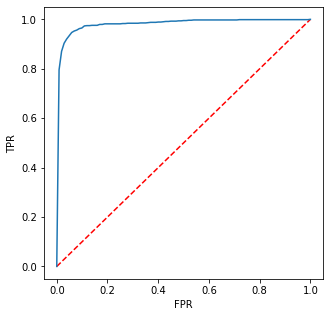

0.748614140797404

In [9]:
isFraud_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                           labelCol='isFraud')
testmodel = lrModel.evaluate(transdata_validation)
predictions = testmodel.predictions
predictions.show(5)
areaUnderCurve = isFraud_eval.evaluate(testmodel.predictions)
print('Test Area Under ROC: ')
plot_roc_cur(lrModel)
areaUnderCurve

Initializing Live Feeds stream for Alerting

In [10]:
producer = KafkaProducer(
#    bootstrap_servers=['localhost:9999'],
    bootstrap_servers=['localhost:9092'],    
    api_version=(0, 10, 1)
)
alertStream=producer.send('SystemStatus', b'Initializing Alert stream!')

In [11]:
def alertTransaction(feed,topic):      
        producer.send(topic, (feed+"").encode('utf-8'))

In [12]:
def process_transaction(df_orig):
    #df_orig = sqlContext.createDataFrame(rdd, schema)
    df = df_orig.select('amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')
    df = df.withColumn("Error_Orig",F.col("oldbalanceOrg") - F.col("newbalanceOrig") - F.col("amount"))
    df = df.withColumn("Error_Dest",F.col("oldbalanceDest") - F.col("newbalanceDest") + F.col("amount"))
    
    #---------- Invoking model for prediction --------------
    assembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                                       'newbalanceDest', 'Error_Orig', 'Error_Dest'], 
                            outputCol='features') 
    ml_df = assembler.transform(df)
    trans_df = ml_df.select('features')
    
    # Prediction
    prediction = lrModel.transform(trans_df)
    prediction_f = prediction.select('prediction')
    df_orig = df_orig.withColumn("id", F.monotonically_increasing_id())
    prediction_f = prediction_f.withColumn("id", F.monotonically_increasing_id())
    df_mrg = df_orig.join(prediction_f, on='id', how='inner').drop("id")

    # processing complete - Publishing it to other downstream services for consumption.
    for row in df_mrg.rdd.collect():
        feed = " " + str(row)
        if row['prediction'] == 0:
            print("Success:" + feed)
            #Messaging services can consume from this Topic - SuccesfullTransactionFeed
            alertTransaction("Success:" + feed,'SuccesfullTransactionFeed') 
        else:
            print("Flagged:" + feed)
            #Seurity messaging services can consume from this Topic - FraudTransactionFeed
            alertTransaction("Flagged:" + feed,'FraudTransactionFeed')  

In [13]:
def tryeval(val):
    try:
        val = ast.literal_eval(val)
    except ValueError:
        pass
    return val

In [14]:
def flag_fraud_transaction(rdd):
    if rdd.isEmpty():
        return 
    list = []
    rdd.foreach(lambda rec: open(r"master_dataset.csv", "a").write(','.join(filter(None, rec))+'\n'))
    list = rdd.map(lambda rec: [tryeval(x) for x in rec[1].split(',')]).collect()
    #master_data = [tryeval(x) for x in list]
    #print(list)
    #rdd.foreach(lambda row: list.append('%'.join(filter(None, row)).split('%')))
    # create dataframe
    df = sparkContext.parallelize(list).toDF(["step","type","amount","nameOrig","oldbalanceOrg","newbalanceOrig","nameDest","oldbalanceDest","newbalanceDest"])
    process_transaction(df)

Model Building - Complete, System Ready for classification

Start Stream Processing from Kafka Topic - LiveFeed

In [15]:
#Create a DStream that will connect to Kafka Broker at localhost:9092
topic='LiveFeed'
brokers='localhost:9092'
f = open(r'master_dataset.csv', 'w')
f.close()
kafkaStream = KafkaUtils.createDirectStream(streamingSparkContext, [topic], {"metadata.broker.list": brokers})

In [16]:
lines = kafkaStream.map(lambda x: x[1])
type(lines)

#def savetheresult( rdd ):
#    if not rdd.isEmpty():
#        rdd.foreach(lambda rec: open(r"master_dataset.csv", "a").write(','.join(filter(None, rec))+'\n'))       
#kafkaStream.foreachRDD(savetheresult)

kafkaStream.foreachRDD(flag_fraud_transaction)
#lines.pprint()

Fraud Detection System is Running.

In [ ]:
streamingSparkContext.start()             # Start the computation
streamingSparkContext.awaitTermination()  # Wait for the computation to terminate

Success: Row(step=6, type='PAYMENT', amount=10438.03, nameOrig='C1471230198', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M1743032972', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=45923.16, nameOrig='C751180603', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M1927763846', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=14479.12, nameOrig='C739241900', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M1874622547', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=5435.22, nameOrig='C1754096028', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M1686106686', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=16906.99, nameOrig='C1933551964', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M992775130', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6

Success: Row(step=6, type='PAYMENT', amount=3724.19, nameOrig='C159851247', oldbalanceOrg=133160.0, newbalanceOrig=129435.81, nameDest='M1167987211', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=7235.23, nameOrig='C265722243', oldbalanceOrg=11350.0, newbalanceOrig=4114.77, nameDest='M574790161', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=10787.1, nameOrig='C477662472', oldbalanceOrg=32933.0, newbalanceOrig=22145.9, nameDest='M719068804', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=3669.27, nameOrig='C308434156', oldbalanceOrg=193.0, newbalanceOrig=0.0, nameDest='M660144865', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=16403.92, nameOrig='C714734087', oldbalanceOrg=21404.0, newbalanceOrig=5000.08, nameDest='M1169734591', oldbalanceDest=0.0, newbalanceDest=0.0, predic

Success: Row(step=6, type='CASH_IN', amount=233628.2, nameOrig='C347042785', oldbalanceOrg=2175307.69, newbalanceOrig=2408935.89, nameDest='C1899073220', oldbalanceDest=3288831.78, newbalanceDest=3382000.83, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=424472.59, nameOrig='C1943679038', oldbalanceOrg=2408935.89, newbalanceOrig=2833408.48, nameDest='C248609774', oldbalanceDest=6515869.35, newbalanceDest=6739716.03, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=220733.04, nameOrig='C844185066', oldbalanceOrg=2833408.48, newbalanceOrig=3054141.52, nameDest='C1339858954', oldbalanceDest=226834.0, newbalanceDest=6100.96, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=120910.43, nameOrig='C604405894', oldbalanceOrg=2833408.48, newbalanceOrig=2833408.48, nameDest='C1636786811', oldbalanceDest=2833408.48, newbalanceDest=6703099.06, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=69196.27, nameOrig='C1561227322', oldbalanceOrg=3054141.52, ne

Success: Row(step=6, type='PAYMENT', amount=7798.05, nameOrig='C1888449414', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M931041456', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=4276.93, nameOrig='C666144990', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M919541414', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=21300.1, nameOrig='C2103374275', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M871019240', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=6034.16, nameOrig='C1037521082', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M2129636512', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=9470.18, nameOrig='C884958895', oldbalanceOrg=0.0, newbalanceOrig=0.0, nameDest='M926303796', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type=

Success: Row(step=6, type='CASH_IN', amount=57520.64, nameOrig='C1016591849', oldbalanceOrg=1299932.01, newbalanceOrig=1357452.65, nameDest='C1475395523', oldbalanceDest=218490.0, newbalanceDest=41304.43, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=44668.48, nameOrig='C854046605', oldbalanceOrg=1357452.65, newbalanceOrig=1402121.13, nameDest='C1789550256', oldbalanceDest=2266171.17, newbalanceDest=3871016.4, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=176065.68, nameOrig='C581318464', oldbalanceOrg=1653522.79, newbalanceOrig=1829588.47, nameDest='C1778801068', oldbalanceDest=8016369.59, newbalanceDest=7468357.55, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=251401.67, nameOrig='C1166259735', oldbalanceOrg=1402121.13, newbalanceOrig=1653522.79, nameDest='C1636786811', oldbalanceDest=5858697.89, newbalanceDest=6703099.06, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=112251.47, nameOrig='C555591232', oldbalanceOrg=1829588.47, n

Success: Row(step=6, type='CASH_IN', amount=51136.63, nameOrig='C1172738852', oldbalanceOrg=7230776.84, newbalanceOrig=7281913.46, nameDest='C1394526584', oldbalanceDest=275036.82, newbalanceDest=618730.52, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=47687.62, nameOrig='C1015658596', oldbalanceOrg=7281913.46, newbalanceOrig=7329601.08, nameDest='C800281454', oldbalanceDest=118172.98, newbalanceDest=70485.36, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=85068.86, nameOrig='C816196187', oldbalanceOrg=7334865.12, newbalanceOrig=7419933.98, nameDest='C644345897', oldbalanceDest=362288.1, newbalanceDest=277219.24, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=5264.04, nameOrig='C872470266', oldbalanceOrg=7329601.08, newbalanceOrig=7334865.12, nameDest='C1615535645', oldbalanceDest=7800.55, newbalanceDest=2536.51, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=133785.78, nameOrig='C1101590744', oldbalanceOrg=7419933.98, newbalanceOrig

Success: Row(step=6, type='CASH_OUT', amount=148971.75, nameOrig='C1846347146', oldbalanceOrg=33979.53, newbalanceOrig=0.0, nameDest='C481402298', oldbalanceDest=287165.23, newbalanceDest=2274476.83, prediction=0.0)
Success: Row(step=6, type='CASH_IN', amount=385890.6, nameOrig='C1051786632', oldbalanceOrg=4322.0, newbalanceOrig=390212.6, nameDest='C304406966', oldbalanceDest=55452.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=28369.96, nameOrig='C1315209017', oldbalanceOrg=66292.0, newbalanceOrig=37922.04, nameDest='M2004981696', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='PAYMENT', amount=32168.72, nameOrig='C182203204', oldbalanceOrg=559.0, newbalanceOrig=0.0, nameDest='M1212351214', oldbalanceDest=0.0, newbalanceDest=0.0, prediction=0.0)
Success: Row(step=6, type='CASH_OUT', amount=8013.4, nameOrig='C472702055', oldbalanceOrg=37922.04, newbalanceOrig=29908.64, nameDest='C478124129', oldbalanceDest=98714.61,